In [101]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    return pd.read_sql_query(query, conn)

## Degree Categorization

From a simple graph perspective a basic entity hierachy can be estabilished:
An entity
- is a sink, if it has an outdegree of 0
- is a source, if it has an indegree of 0
- is a connector, otherwise

Furthermore, a connector can be **emptied** if its balance is (almost) 0 USD or **not**
Lastly, an entity can be **simple**, if its out- and indegree are 0 or 1 or **complex** if its out- and indegree are bigger than that.

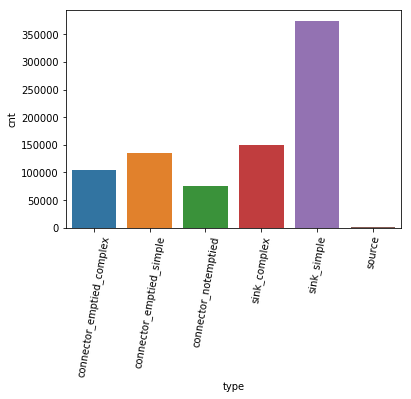

In [81]:
graphProperties = sql('''
SELECT "sink_simple" as type, count(*) as cnt FROM EntityMetadata WHERE indegree = 1 and outdegree = 0
UNION
SELECT "sink_complex", count(*) FROM EntityMetadata WHERE indegree > 1 and outdegree = 0
UNION
SELECT "source", count(*) FROM EntityMetadata WHERE indegree = 0 and outdegree > 0
UNION
SELECT "connector_emptied_simple", count(*) FROM EntityMetadata 
WHERE 
    indegree = 1 and outdegree = 1 and involumeUSD - outvolumeUSD between -0.05 and 0.05
UNION
SELECT "connector_emptied_complex", count(*) FROM EntityMetadata 
WHERE 
    indegree > 0 and outdegree > 0 and involumeUSD - outvolumeUSD between -0.05 and 0.05 and outdegree + indegree > 2
UNION
SELECT "connector_notemptied", count(*) FROM EntityMetadata 
WHERE 
    indegree > 0 and outdegree > 0 and not involumeUSD - outvolumeUSD between -0.05 and 0.05
''')
ax = sns.barplot(data=graphProperties, x='type', y='cnt')
plt.xticks(rotation=80)
plt.show()

Text(0.5, 0, 'last activity [d since first transfer]')

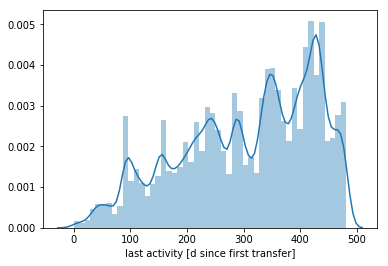

In [66]:
time_dist = sql('''
SELECT t.`from` as address,max(t.timestamp) as last_active FROM 
ETransfer t
GROUP BY t.`from`
''')
time_dist['last_active'] = pd.to_datetime(time_dist['last_active'])
first_date = time_dist['last_active'].min()
time_dist['last_activity'] = time_dist['last_active'].apply(lambda d: (d - first_date).days)
ax = sns.distplot(time_dist['last_activity'])
ax.set_xlabel('last activity [d since first transfer]')
plt.show()

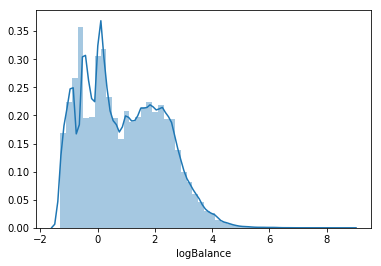

In [112]:
balances = sql('''SELECT name, involumeUSD - outvolumeUSD as balance from EntityMetadata WHERE balance > 0.05''')
balances['logBalance'] = balances['balance'].apply(np.log10)
ax = sns.distplot(balances['logBalance'])
#ax.set(yscale="log")
plt.show()

Index(['address', 'indegree', 'outdegree', 'degree', 'distinctDegree',
       'distinctInDegree', 'distinctOutDegree', 'behavedLikeDepositAddress',
       'involumeUSD', 'outvolumeUSD', 'outdegreeFraction', 'outvolumeFraction',
       'isConcentrator', 'isMixer', 'isDiluter', 'firstOutBlocknumber',
       'canBePaperWallet'],
      dtype='object')


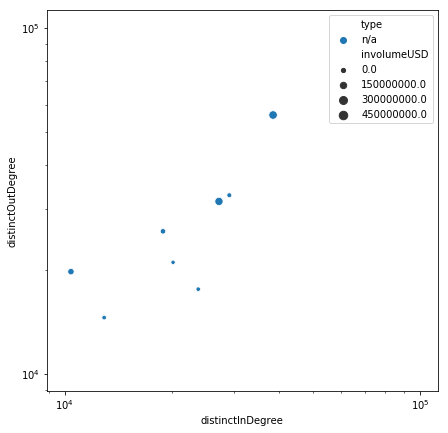

In [91]:
df = sql('SELECT * FROM AddressMetadata WHERE distinctDegree >= 100')
print(df.columns)

df['type'] = "n/a"

df.loc[df['isDiluter'] == 1, ['type']] = 'diluter'
df.loc[df['isMixer'] == 1, ['type']] = 'mixer'
df.loc[df['isConcentrator'] == 1, ['type']] = 'concentrator'

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='distinctInDegree', y='distinctOutDegree', hue="type", size="involumeUSD", data=df, ax=ax)